This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [83]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os

# Reloading
from importlib import reload

# Local imports
import sys
sys.path.append('../../../../')
import imagestuff as ims
import retrievestuff as rs
import f90nml
import gradstuff as gds
import statstuff as sts

In [84]:
%matplotlib notebook

In [85]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentnamelistroot = 'Segments1'
imageroot = 'case1.0'
Calibrationfile = 'Calibration.nml'

/Users/erinthill/Documents/GitHub/ice2021/crystals/2023-07-25/70pa/case1.0 (calibration) second try
2023-07-25/70pa/case1.0 (calibration) second try


In [86]:
# Derivative names
Compressedfilename = Segmentnamelistroot+'_retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentnamelistroot+'_roughness.jpg'; print(Roughnessfile)
Roughnessdatafile = Segmentnamelistroot+'_roughness.txt'; print(Roughnessdatafile)

Segments1_retrieved.npz
Segments1_roughness.jpg
Segments1_roughness.txt


In [87]:
# These are derivative names
Segmentnamelist = Segmentnamelistroot+'.nml'
Segmentfile = Segmentnamelist
SEMSegmentjpgfile =  Segmentnamelistroot+'.jpg'
Retrievedjpgfile =   Segmentnamelistroot+'_retrieved.jpg'
Compressedfilename = Segmentnamelistroot+'_retrieved'

In [88]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot,'A')
print("Filename, dx and dy", Filename, dx, dy)

SEMimages/case1.0-A.bmp
SEMimages/case1.0-B.bmp
SEMimages/case1.0-C.bmp
SEMimages/case1.0-D.bmp
Filename, dx and dy SEMimages/case1.0-A.bmp 1.526442 1.526442


In [89]:
# Extract the desired segments
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

Benchmark score for random signals = 7.234257585282823
Correlation of detectors A-D for each segment
for segment  0
nx= 43
ny= 43
0 1 2.712391478162734
0 2 -2.6252989491139966
0 3 0.8519123915390481
1 2 2.412059576827141
1 3 -3.9637128389649696
2 3 -2.734002497548723
Correlation score = 6.631654194424538



<IPython.core.display.Javascript object>


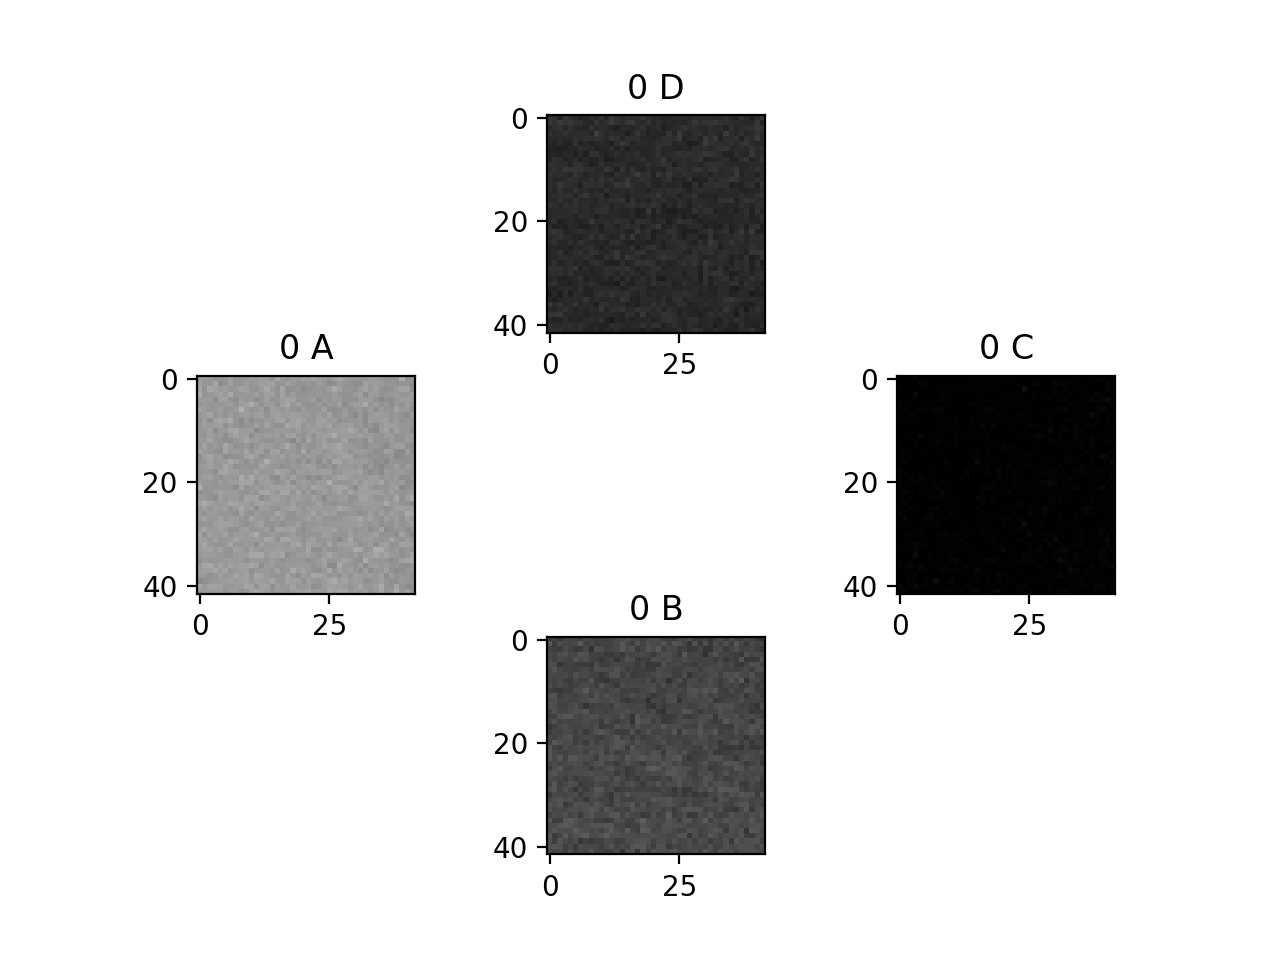

for segment  1
nx= 43
ny= 43
0 1 1.2955440201761552
0 2 2.484857060392824
0 3 1.0343570544012446
1 2 1.2254004423517935
1 3 -2.8399477750754394
2 3 0.8629137042055552
Correlation score = 4.385700982165284



<IPython.core.display.Javascript object>


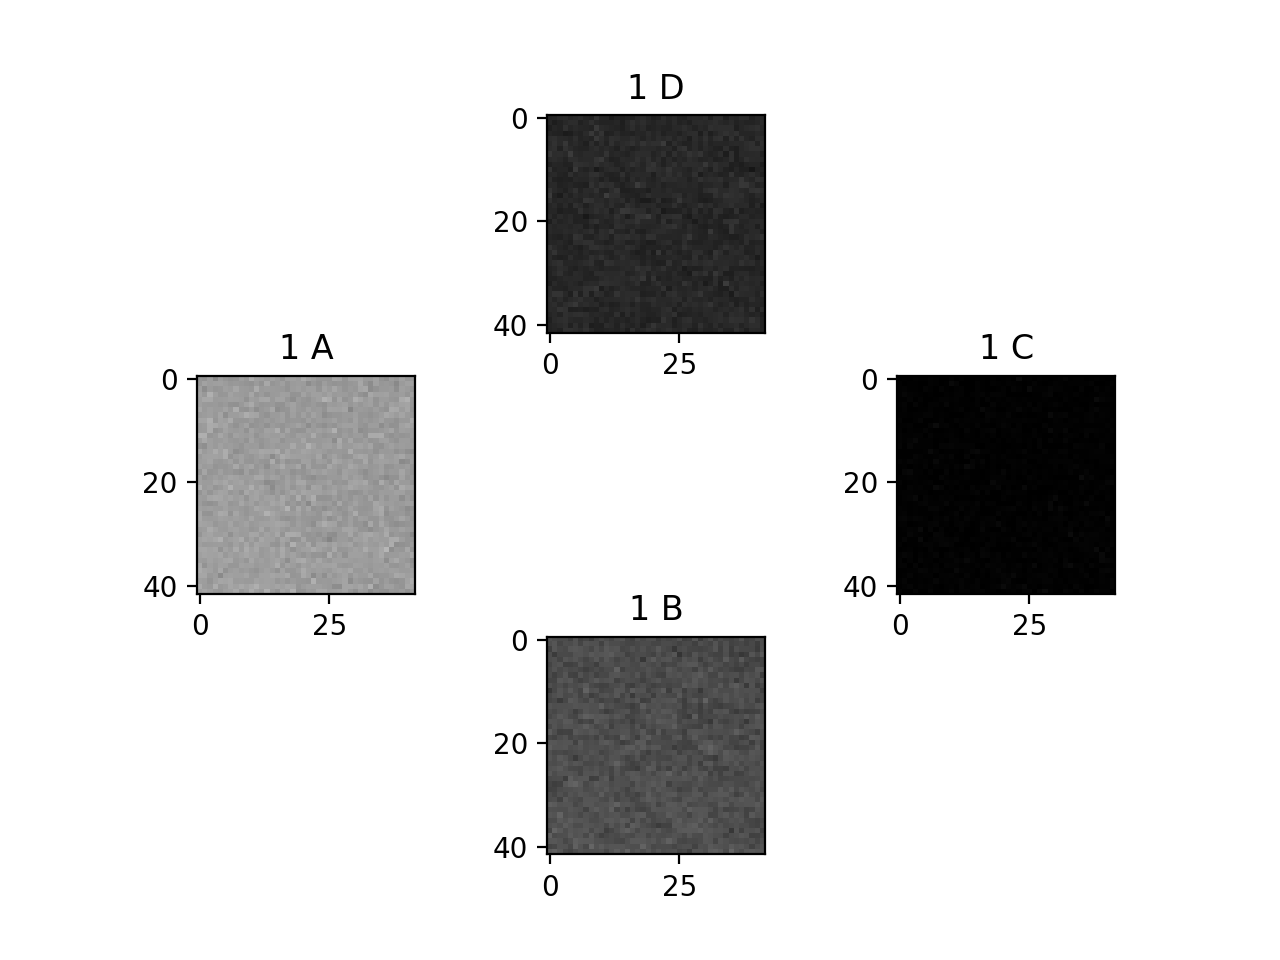

for segment  2
nx= 43
ny= 43
0 1 11.540003081186793
0 2 5.541915154504614
0 3 -3.7904605881074755
1 2 3.3071699030030812
1 3 -2.535608081062113
2 3 -1.169642078045618
Correlation score = 14.035199673048346



<IPython.core.display.Javascript object>


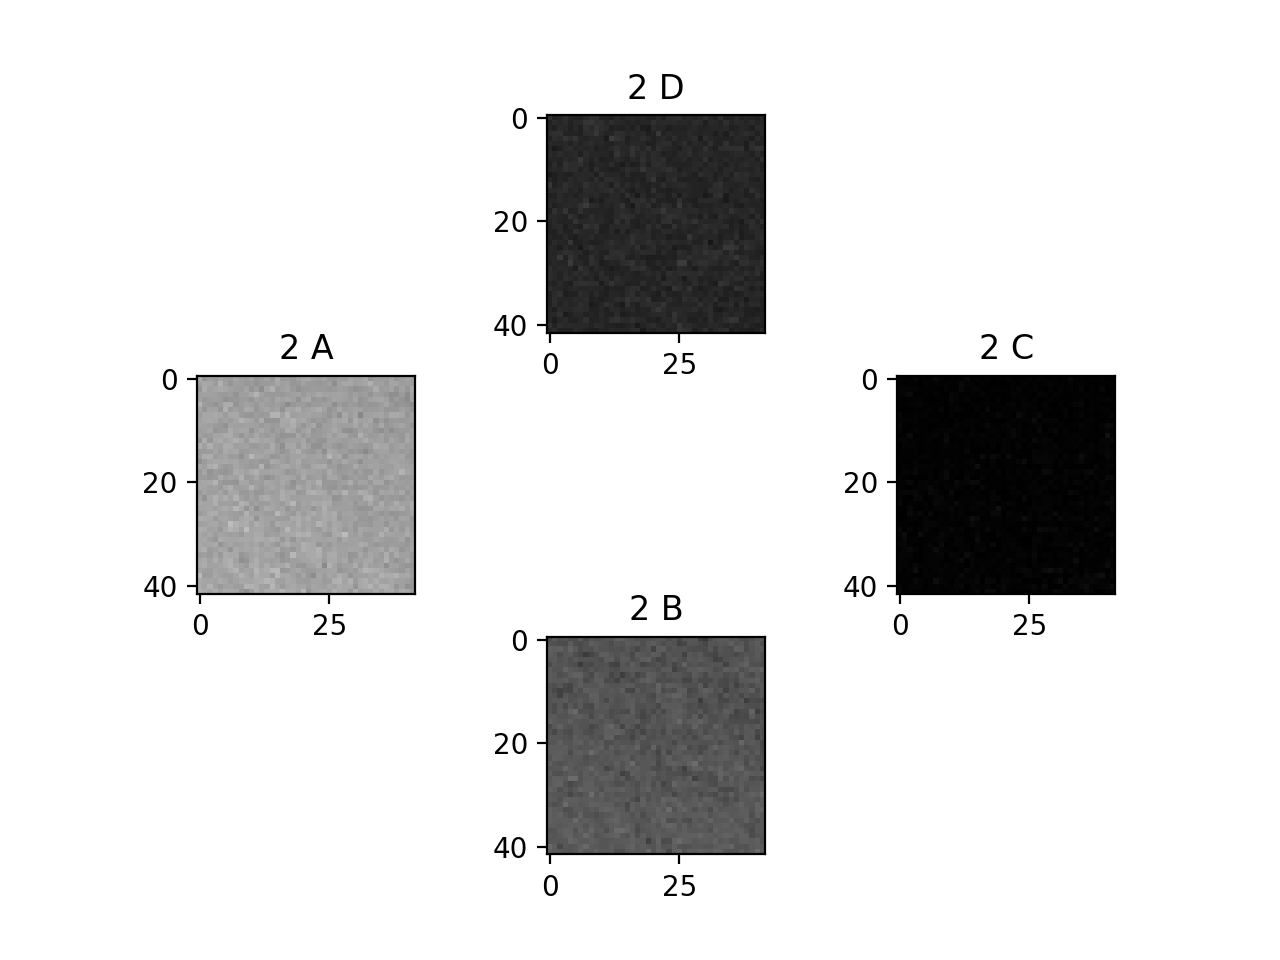

for segment  3
nx= 43
ny= 43
0 1 15.03220274897427
0 2 -34.791911819459536
0 3 -5.932437212900381
1 2 -11.151154464045888
1 3 -4.819151232700803
2 3 3.4282788310187127
Correlation score = 40.385190590762186



<IPython.core.display.Javascript object>


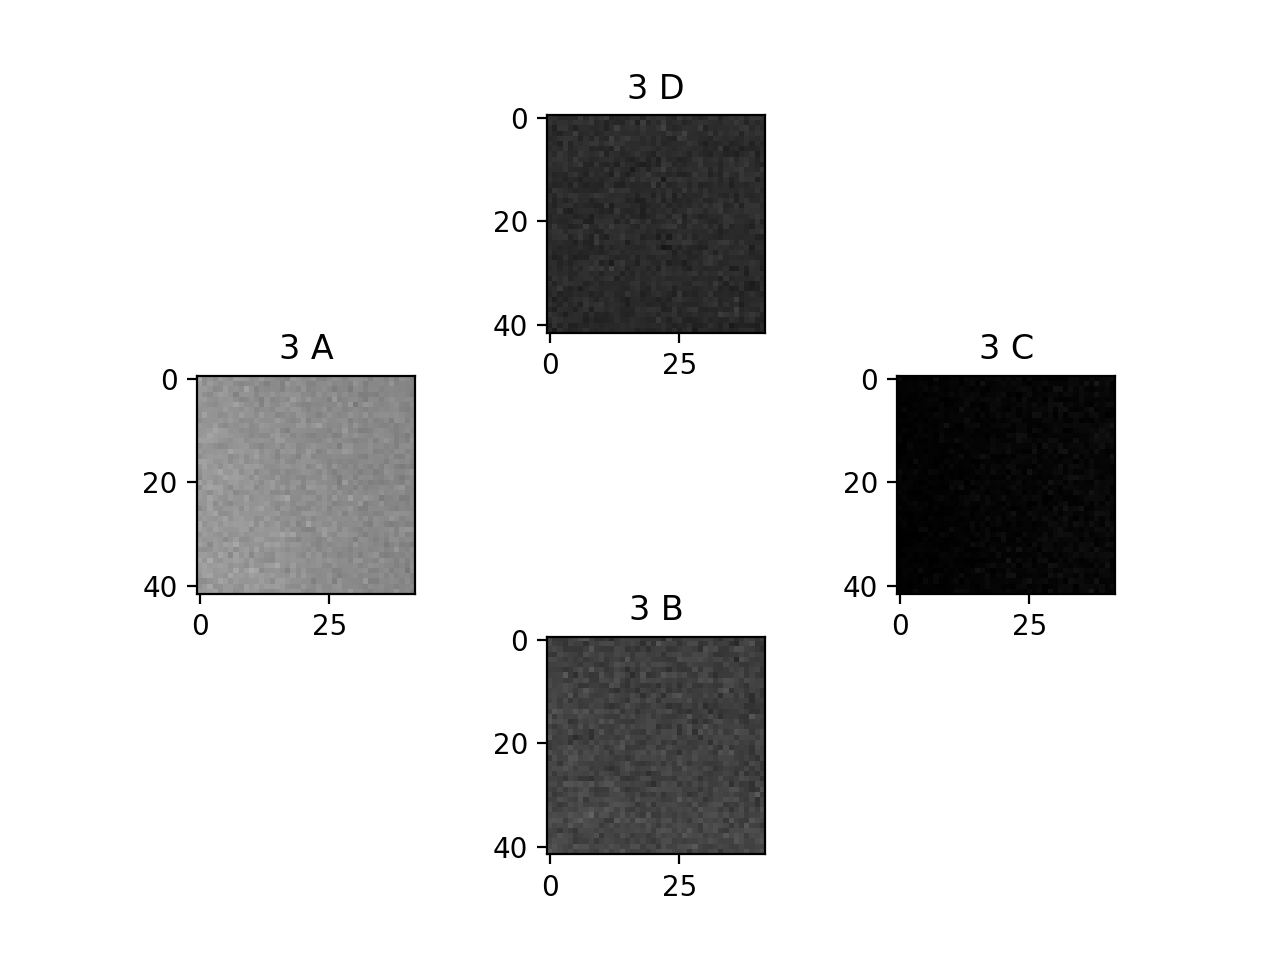

for segment  4
nx= 43
ny= 43
0 1 6.39866841812005
0 2 -41.14720981370756
0 3 3.306686546597147
1 2 -4.01840502376933
1 3 -8.048530089832363
2 3 -5.898822250801649
Correlation score = 43.135745367204564



<IPython.core.display.Javascript object>


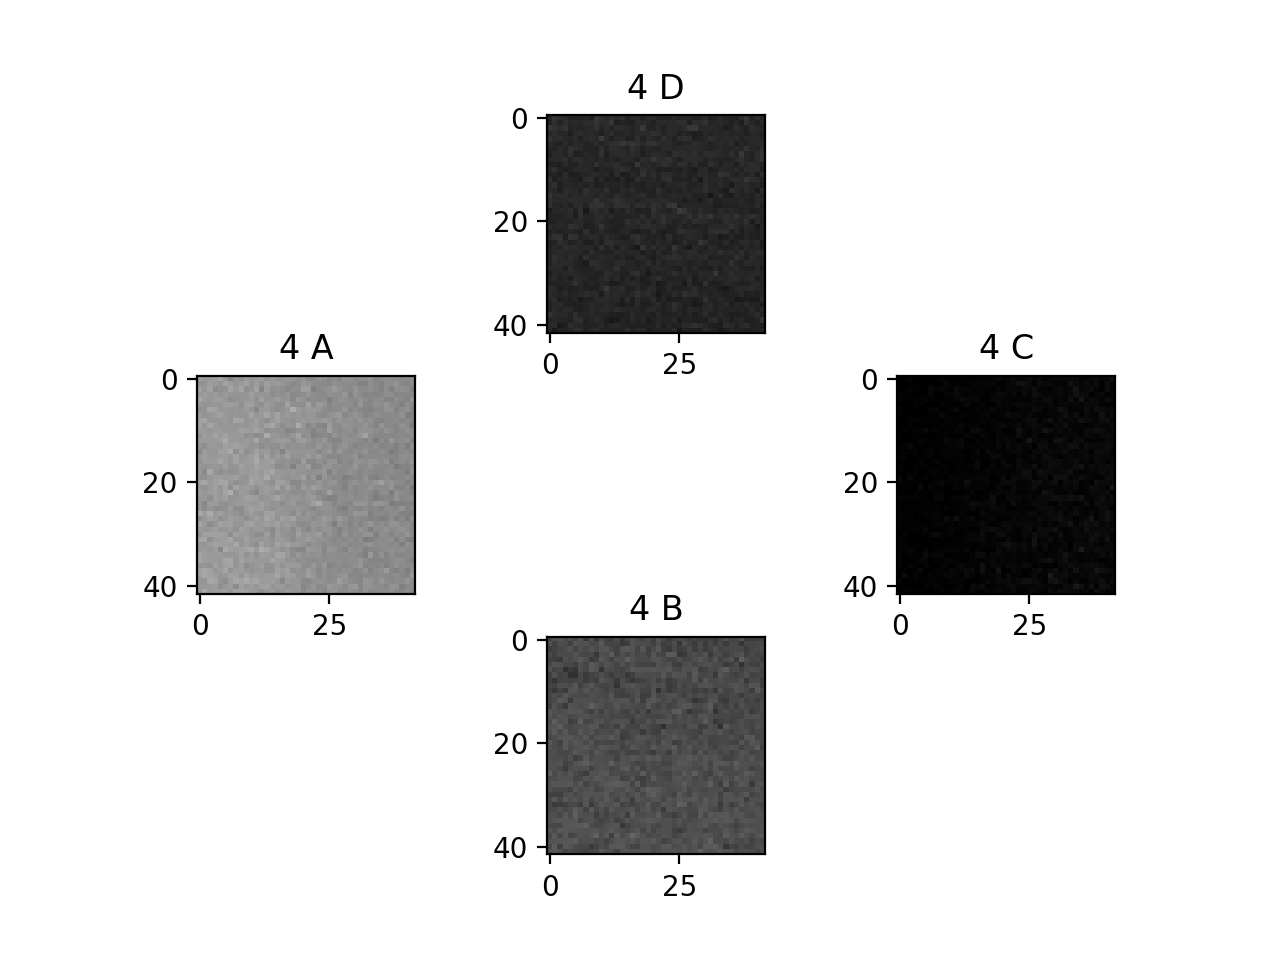

for segment  5
nx= 43
ny= 43
0 1 0.3494512856057614
0 2 -30.79415499275737
0 3 12.308004611605085
1 2 6.350556717937518
1 3 -16.22787158288941
2 3 -11.214705452518535
Correlation score = 39.10667565216337



<IPython.core.display.Javascript object>


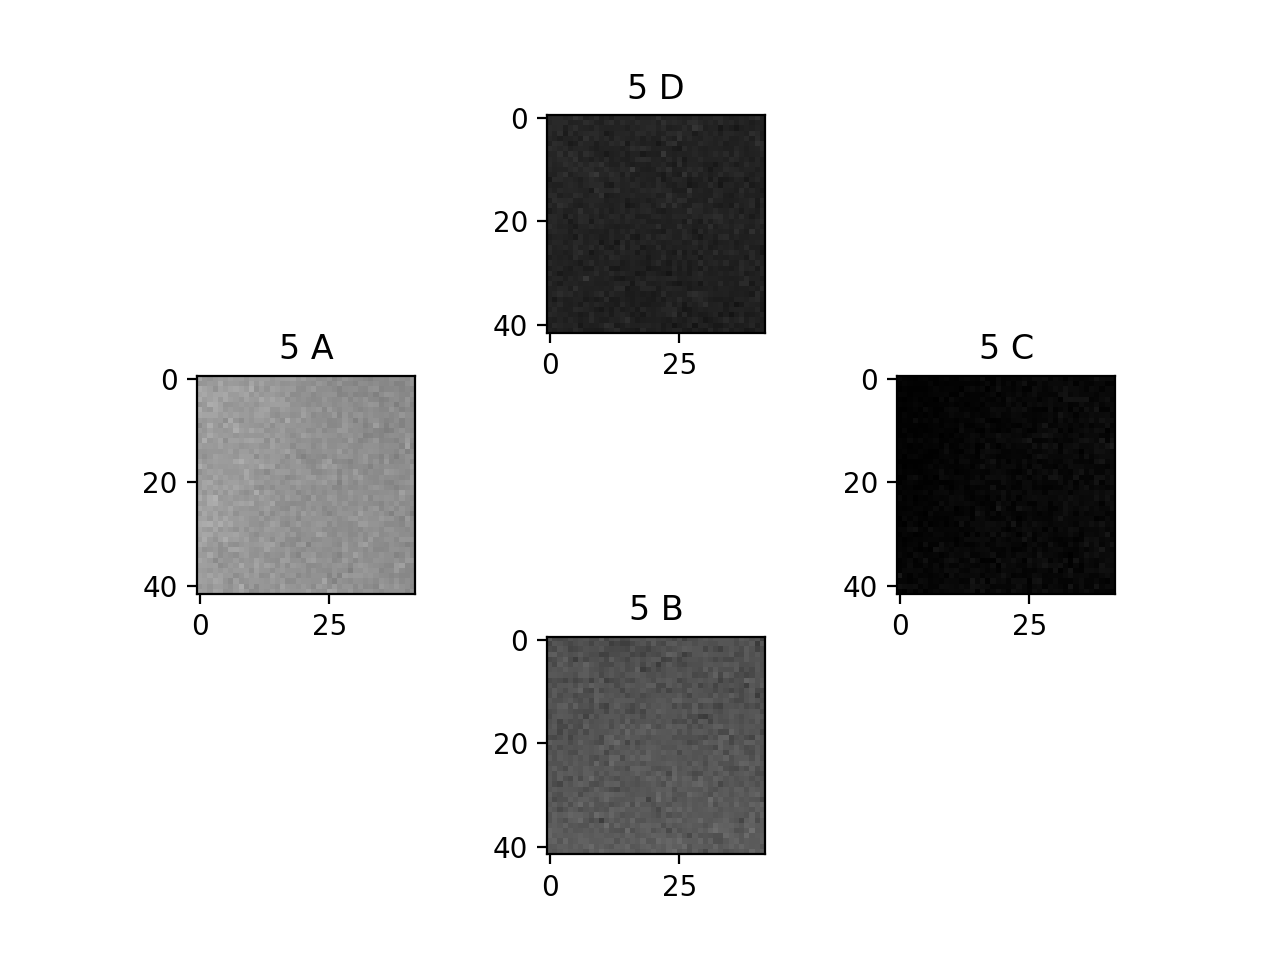

for segment  6
nx= 43
ny= 43
0 1 3.2841213709153596
0 2 -7.3554983779592655
0 3 -3.0018130592870653
1 2 1.5897492692069415
1 3 -7.39930160596292
2 3 -1.0104189781348116
Correlation score = 11.497721718509942



<IPython.core.display.Javascript object>


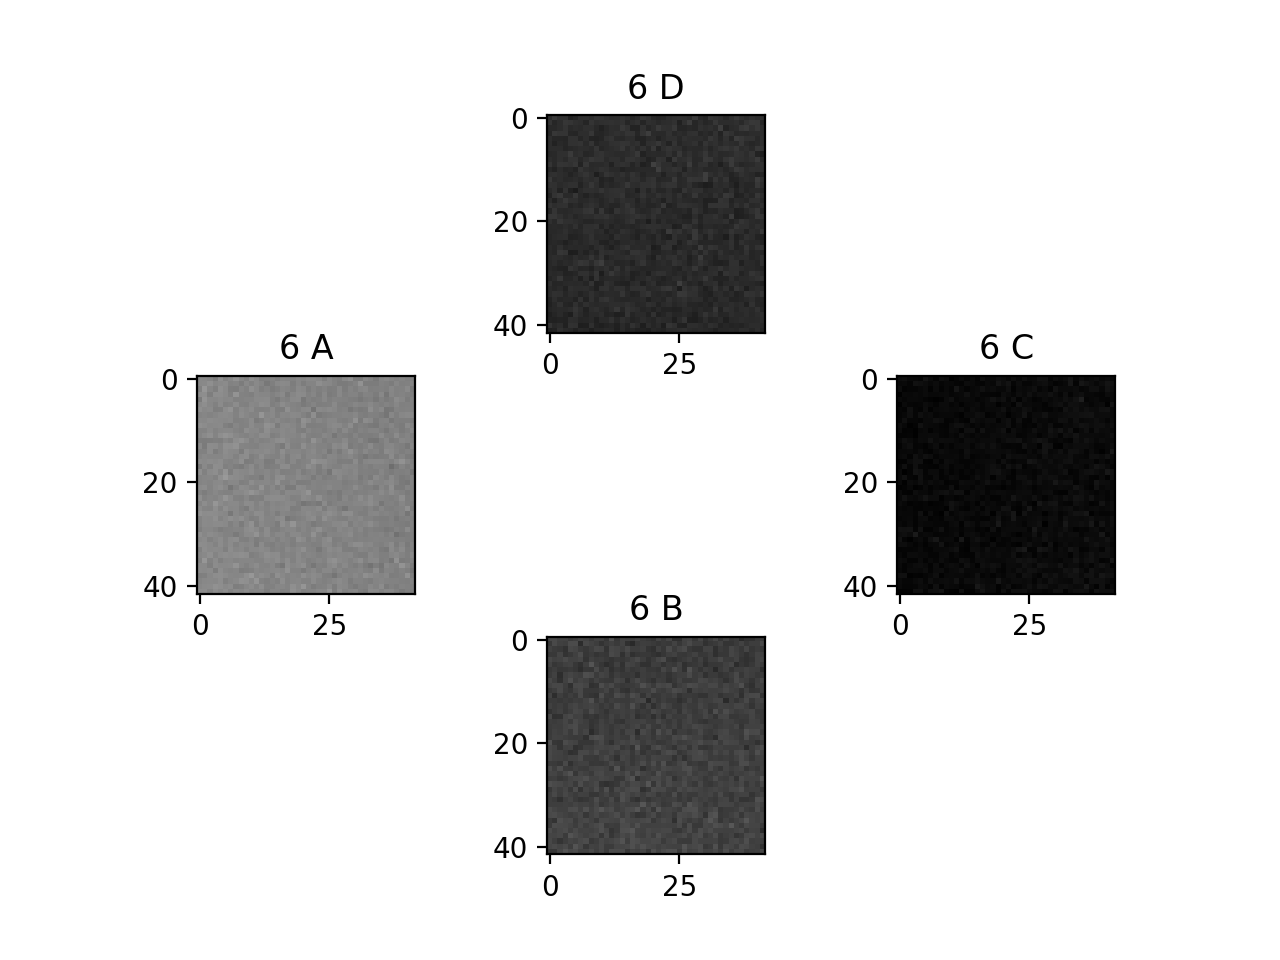

for segment  7
nx= 43
ny= 43
0 1 4.922979725890106
0 2 -8.875488280185452
0 3 0.399356275038573
1 2 -1.350737366361583
1 3 -8.169618340879007
2 3 -2.692370755250809
Correlation score = 13.378547102727145



<IPython.core.display.Javascript object>


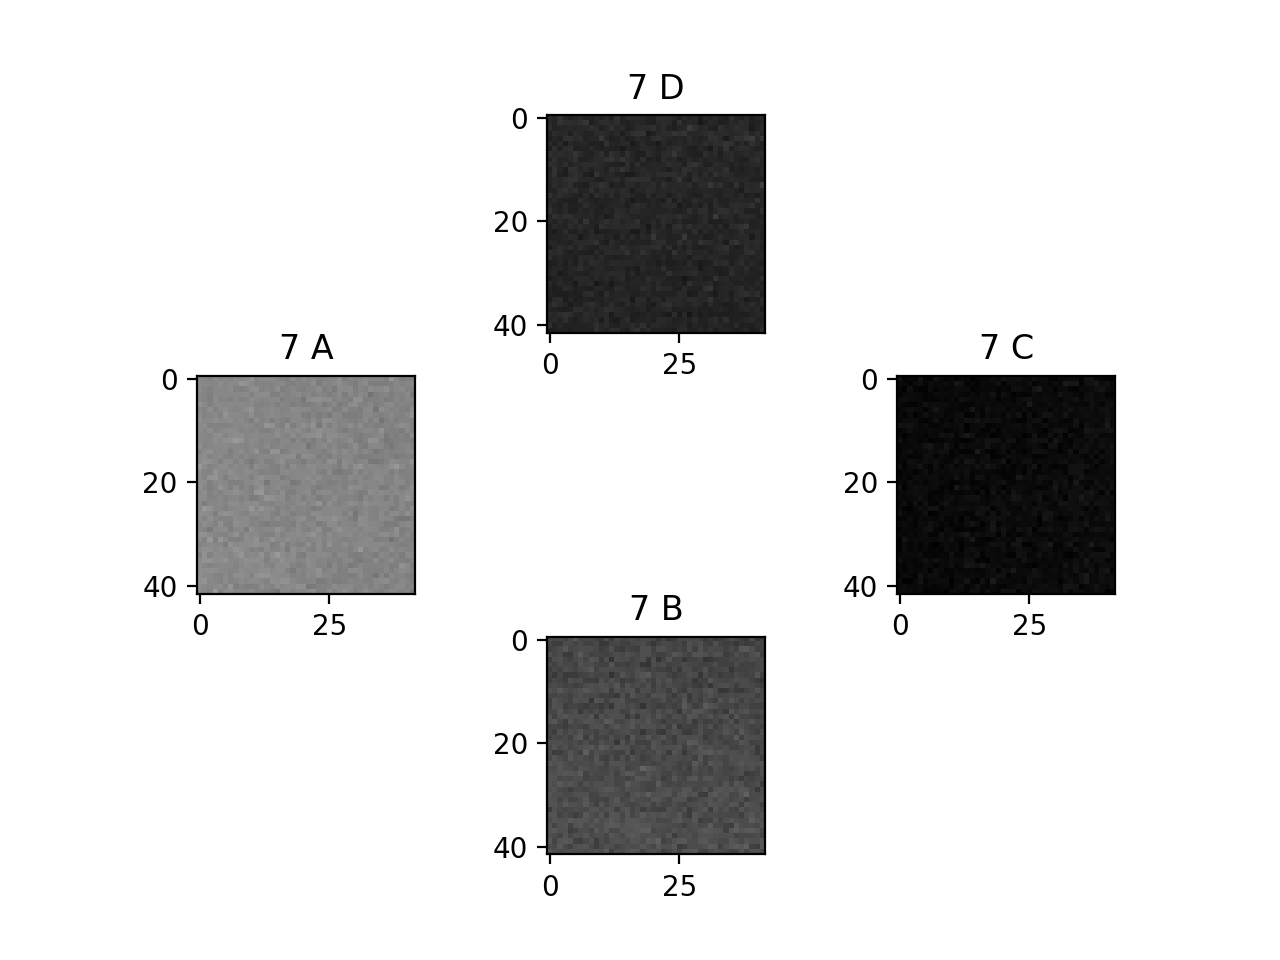

for segment  8
nx= 43
ny= 43
0 1 8.648753149276834
0 2 -4.445448331428606
0 3 -8.54136396255739
1 2 7.441975901268923
1 3 -9.157346068438638
2 3 -3.986177352408333
Correlation score = 17.96238966458724



<IPython.core.display.Javascript object>


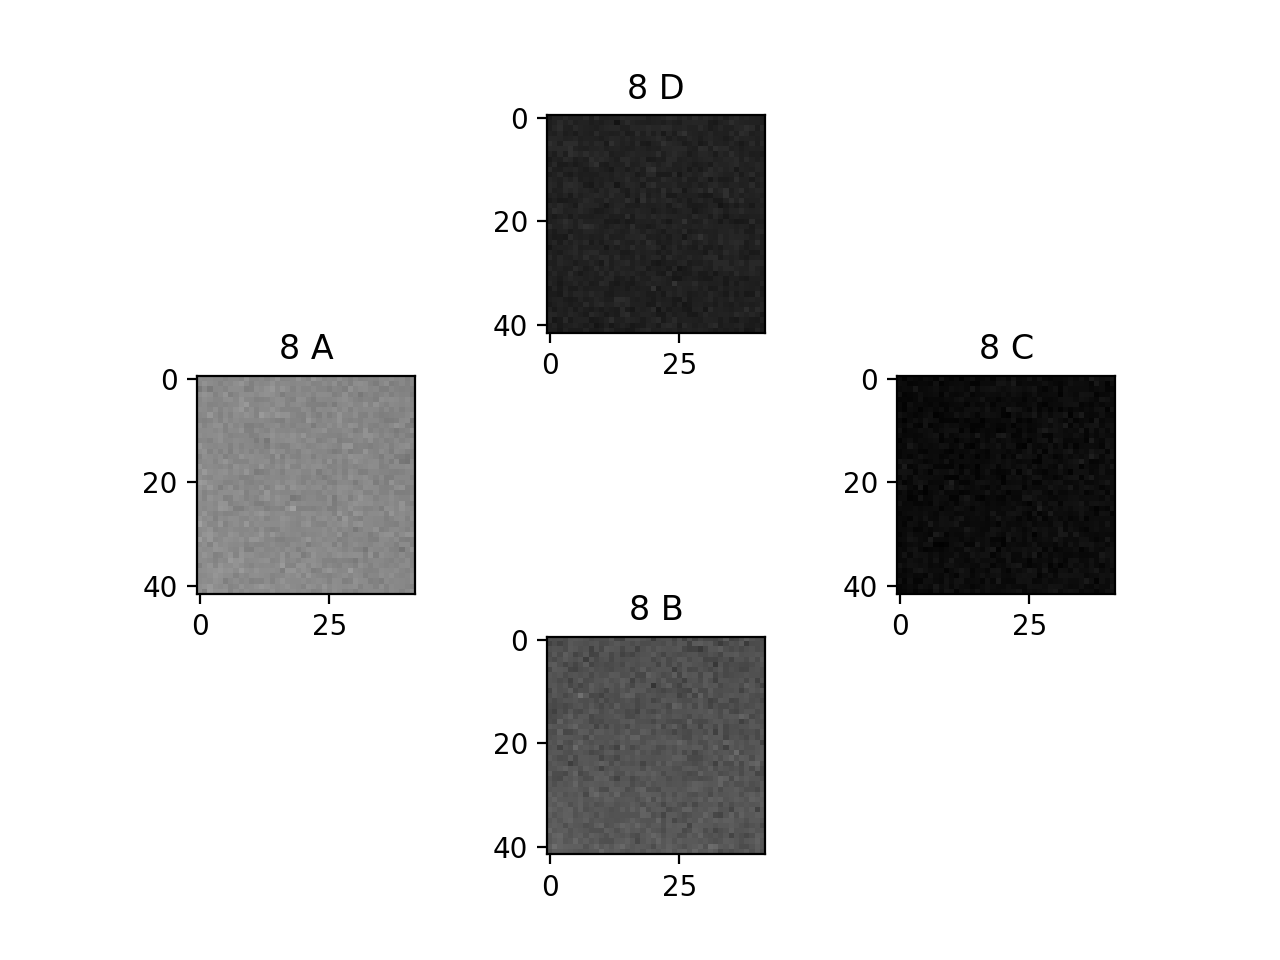

for segment  9
nx= 43
ny= 43
0 1 9.548566278266165
0 2 -5.698601971648521
0 3 -2.6624486107173437
1 2 2.0639042633034057
1 3 -11.275658934783042
2 3 2.960044387767815
Correlation score = 16.459035907537817



<IPython.core.display.Javascript object>


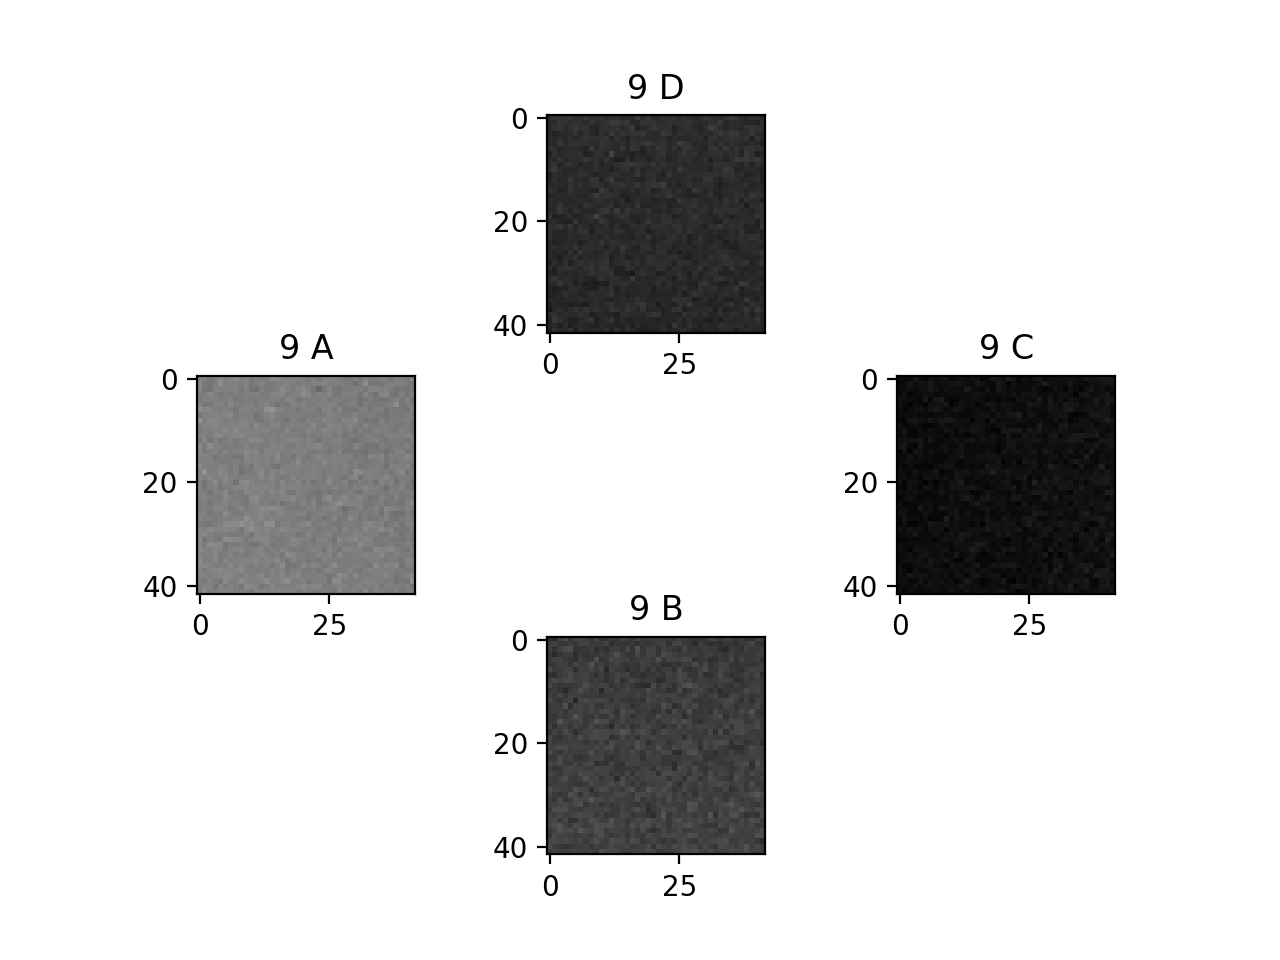

for segment  10
nx= 43
ny= 43
0 1 4.452724846689543
0 2 -12.032928993848266
0 3 -1.0246179805177318
1 2 1.617151599139097
1 3 -10.038431734436054
2 3 -4.68766058549911
Correlation score = 17.059526179929314



<IPython.core.display.Javascript object>


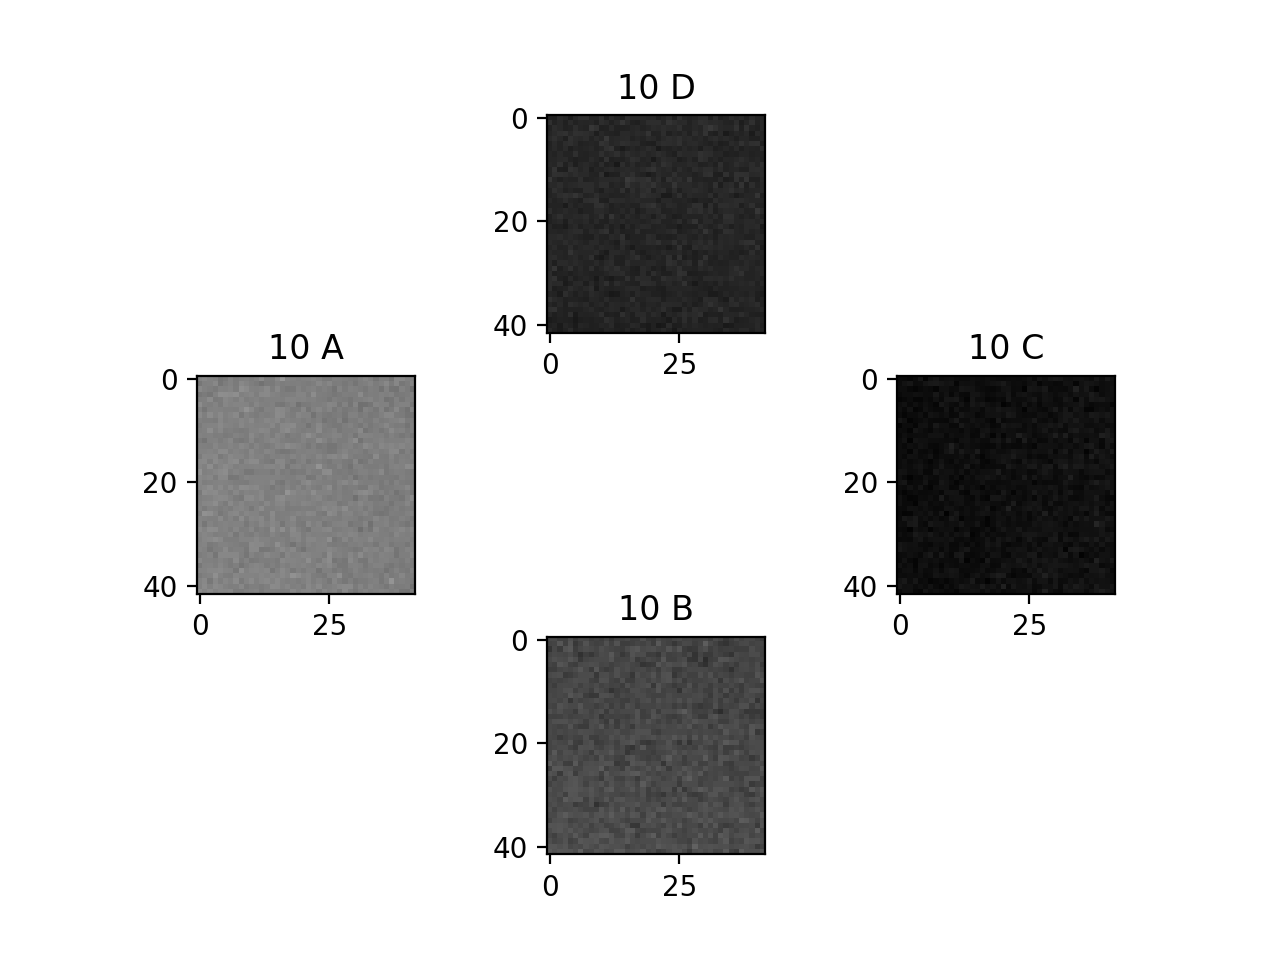

for segment  11
nx= 43
ny= 43
0 1 9.942870362219272
0 2 -1.6127518411685373
0 3 -5.840745380388877
1 2 -1.5247569624231905
1 3 -10.957690098469312
2 3 -6.76243047053965
Correlation score = 17.427055634761096



<IPython.core.display.Javascript object>


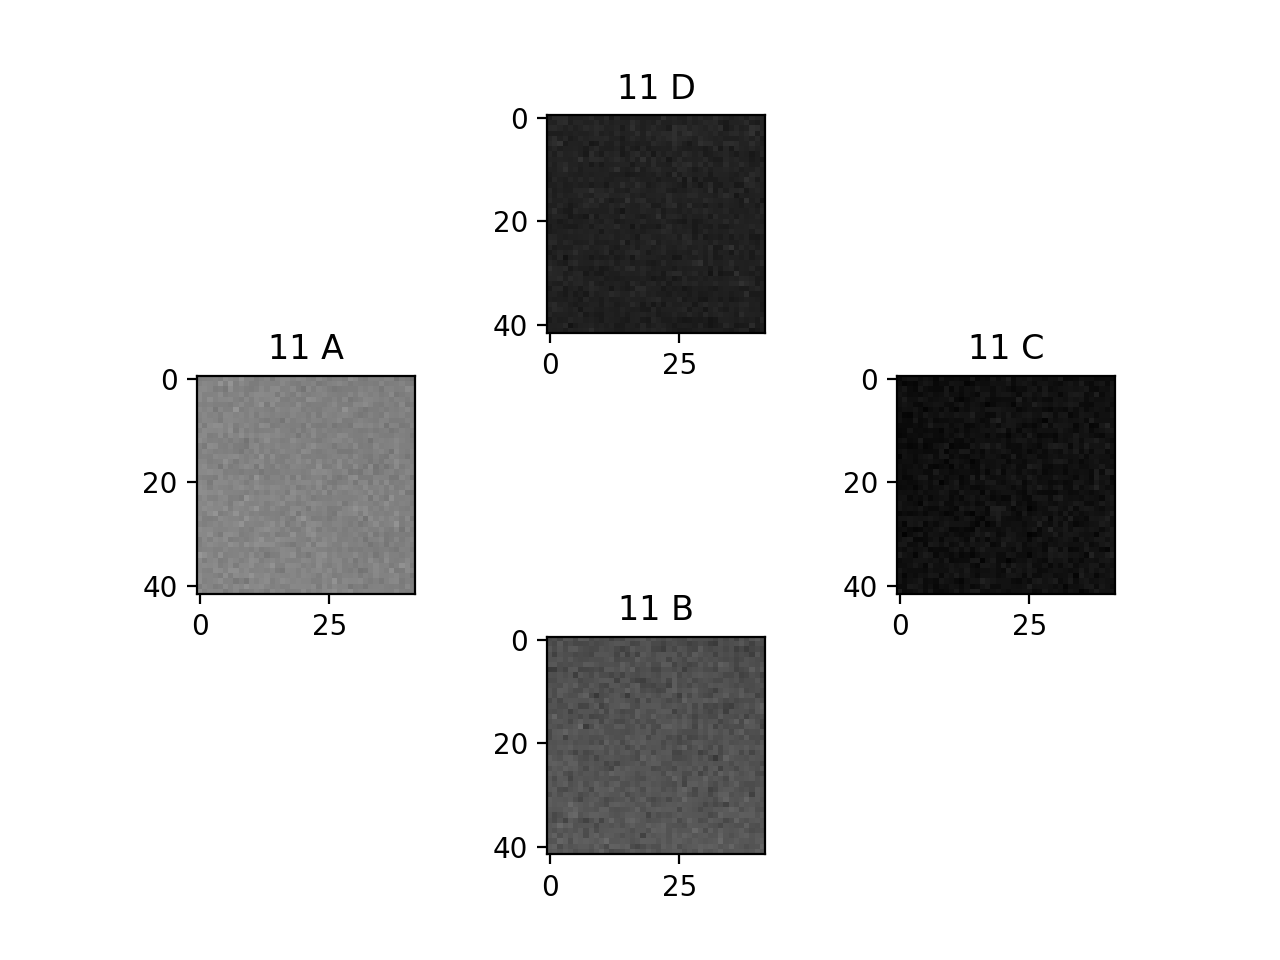

for segment  12
nx= 43
ny= 43
0 1 1.6304160802305507
0 2 -11.805689554965888
0 3 1.7682618325236088
1 2 -1.7605317026599836
1 3 -8.16580866112109
2 3 -0.7897569925763767
Correlation score = 14.682061552952948



<IPython.core.display.Javascript object>


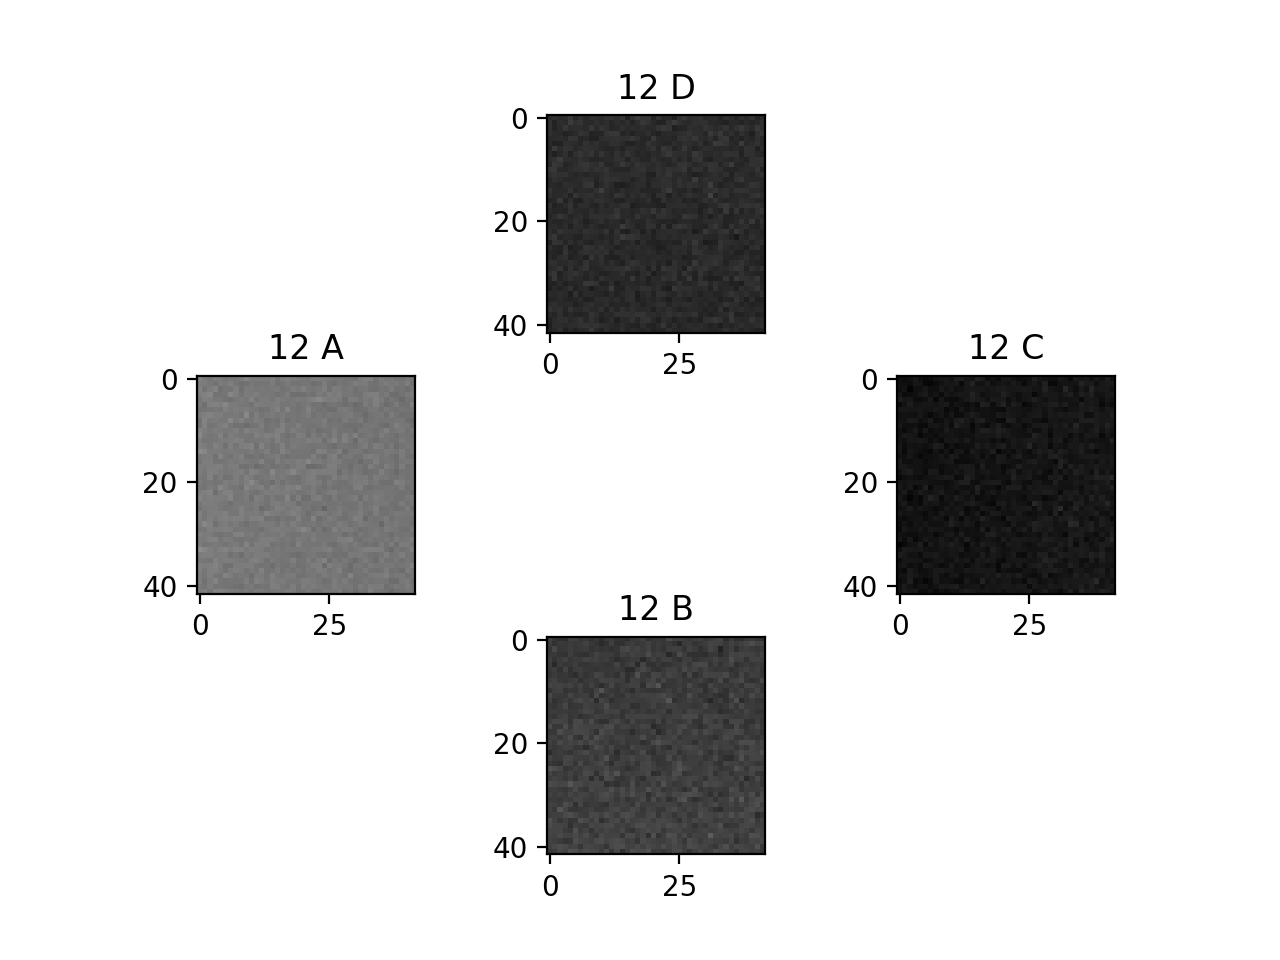

for segment  13
nx= 43
ny= 43
0 1 13.356364688439845
0 2 -9.163212592039566
0 3 -2.6009129429369926
1 2 0.002834469593499343
1 3 -6.616023047867094
2 3 0.46822238189628146
Correlation score = 17.694990591613422



<IPython.core.display.Javascript object>


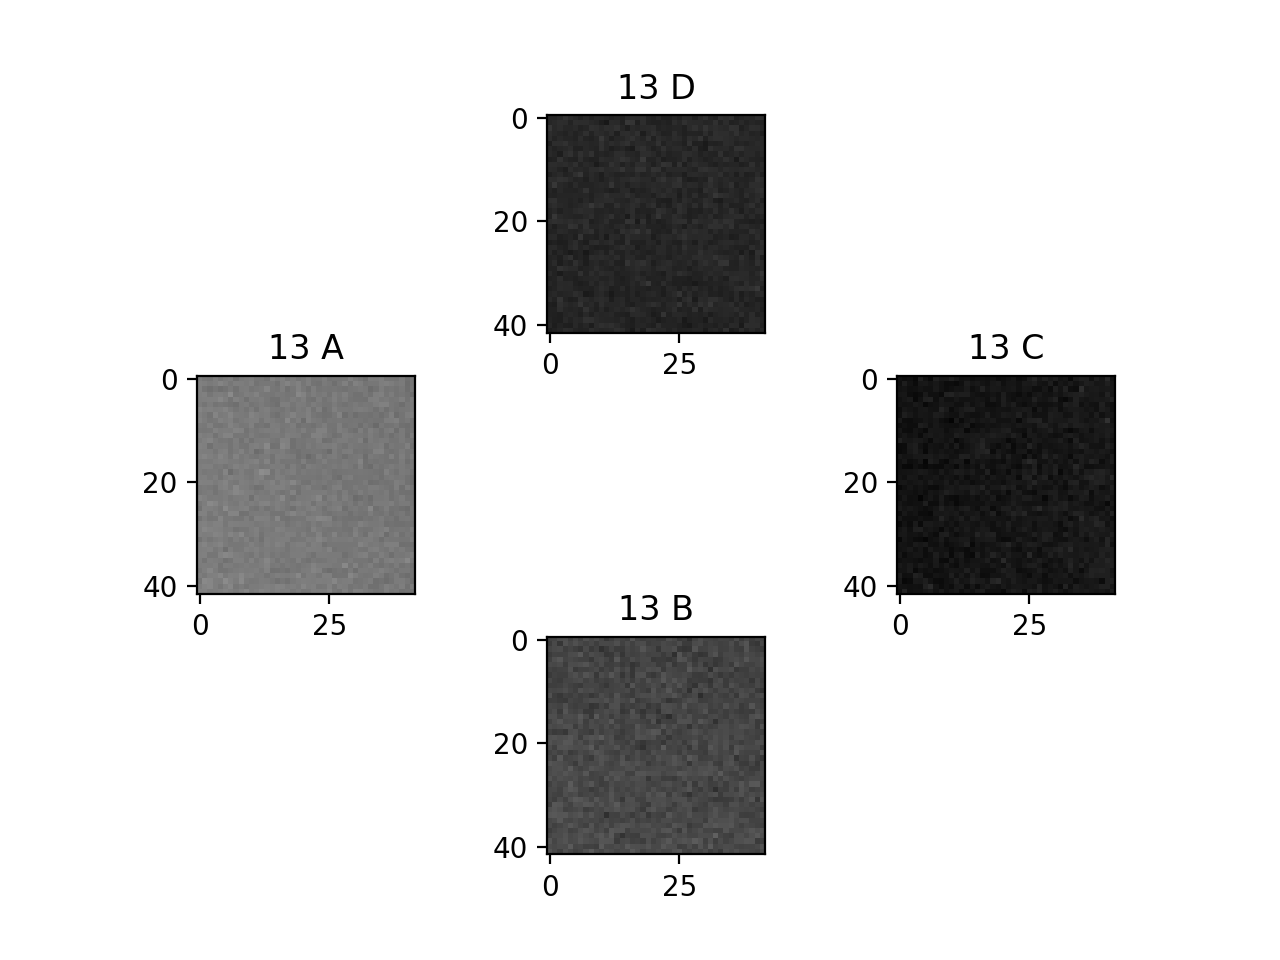

for segment  14
nx= 43
ny= 43
0 1 9.49532275337401
0 2 -29.298681848984952
0 3 -6.4513774963501085
1 2 0.10497901849831845
1 3 -15.53840459945616
2 3 -4.819268422868319
Correlation score = 35.42418058475843



<IPython.core.display.Javascript object>


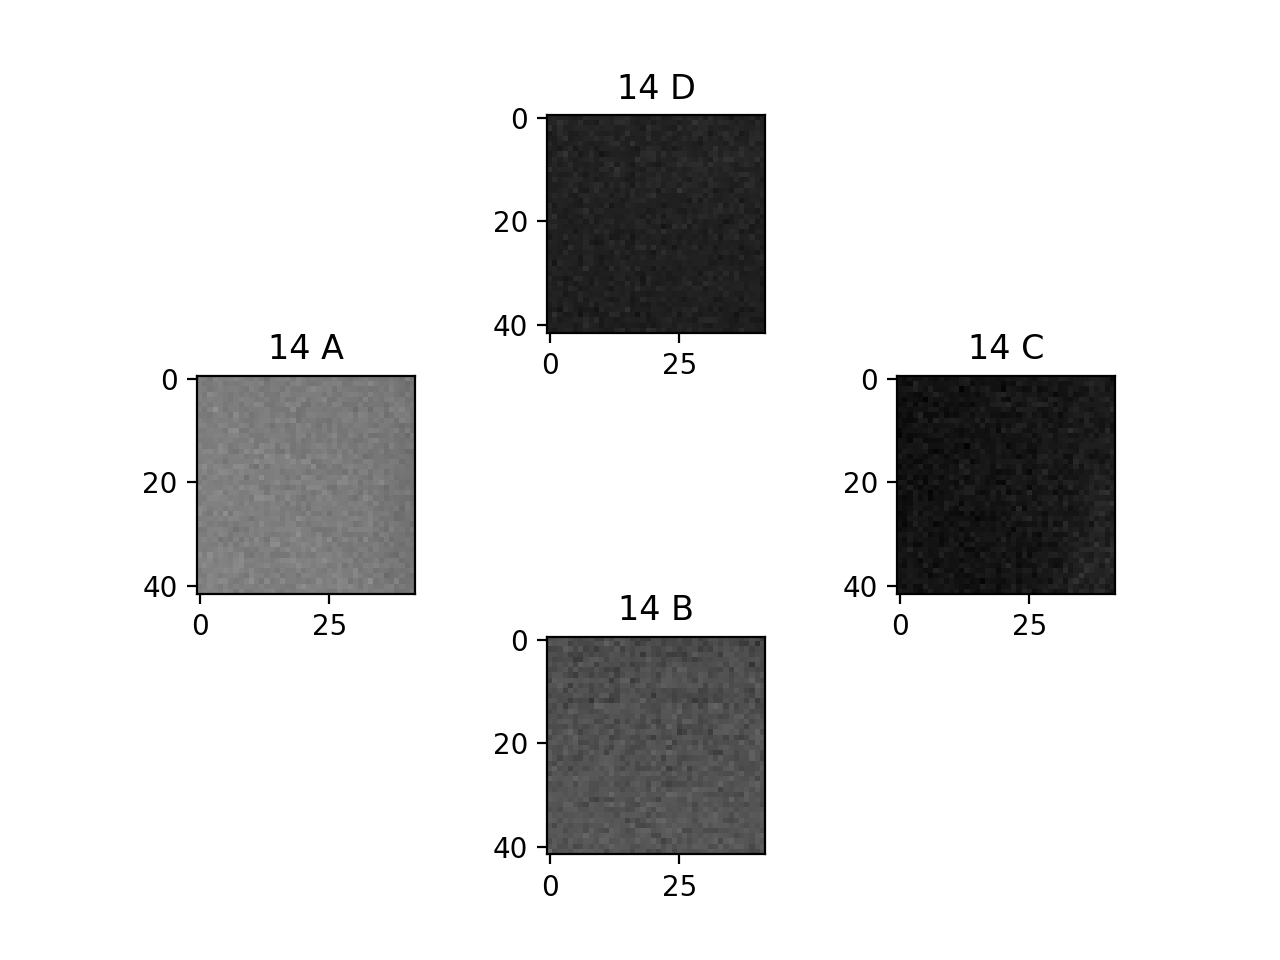

for segment  15
nx= 43
ny= 43
0 1 -0.9141653498545158
0 2 -3.109214717583453
0 3 3.387981542041146
1 2 6.068472593156024
1 3 -6.612235250614351
2 3 -4.61521679797861
Correlation score = 11.12787374532172



<IPython.core.display.Javascript object>


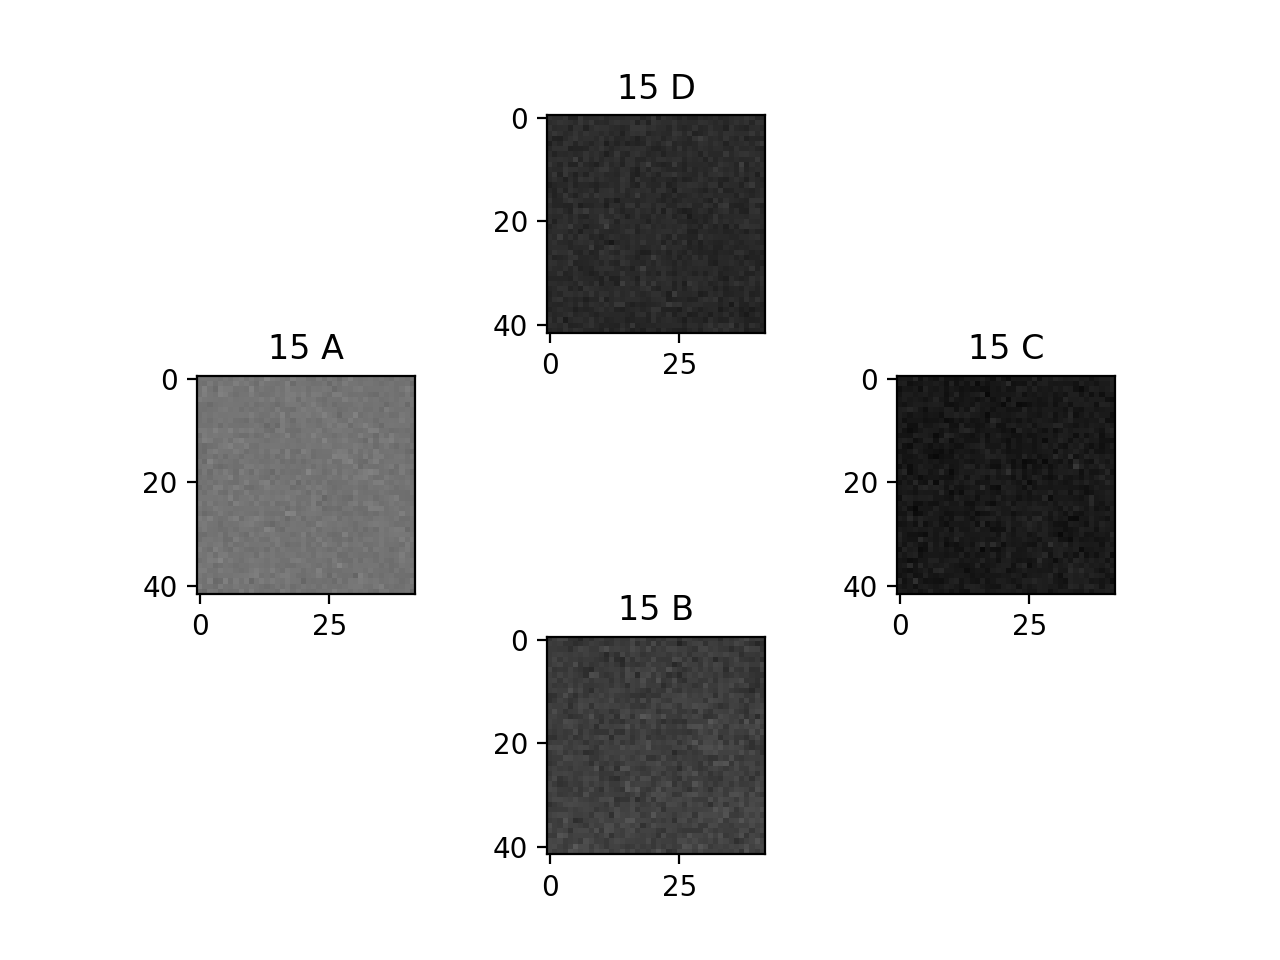

for segment  16
nx= 43
ny= 43
0 1 -14.717824506815472
0 2 -19.624278879313778
0 3 17.185636018406576
1 2 18.936645606408934
1 3 -21.520561830708655
2 3 -22.88814498690968
Correlation score = 47.35684823103763



<IPython.core.display.Javascript object>


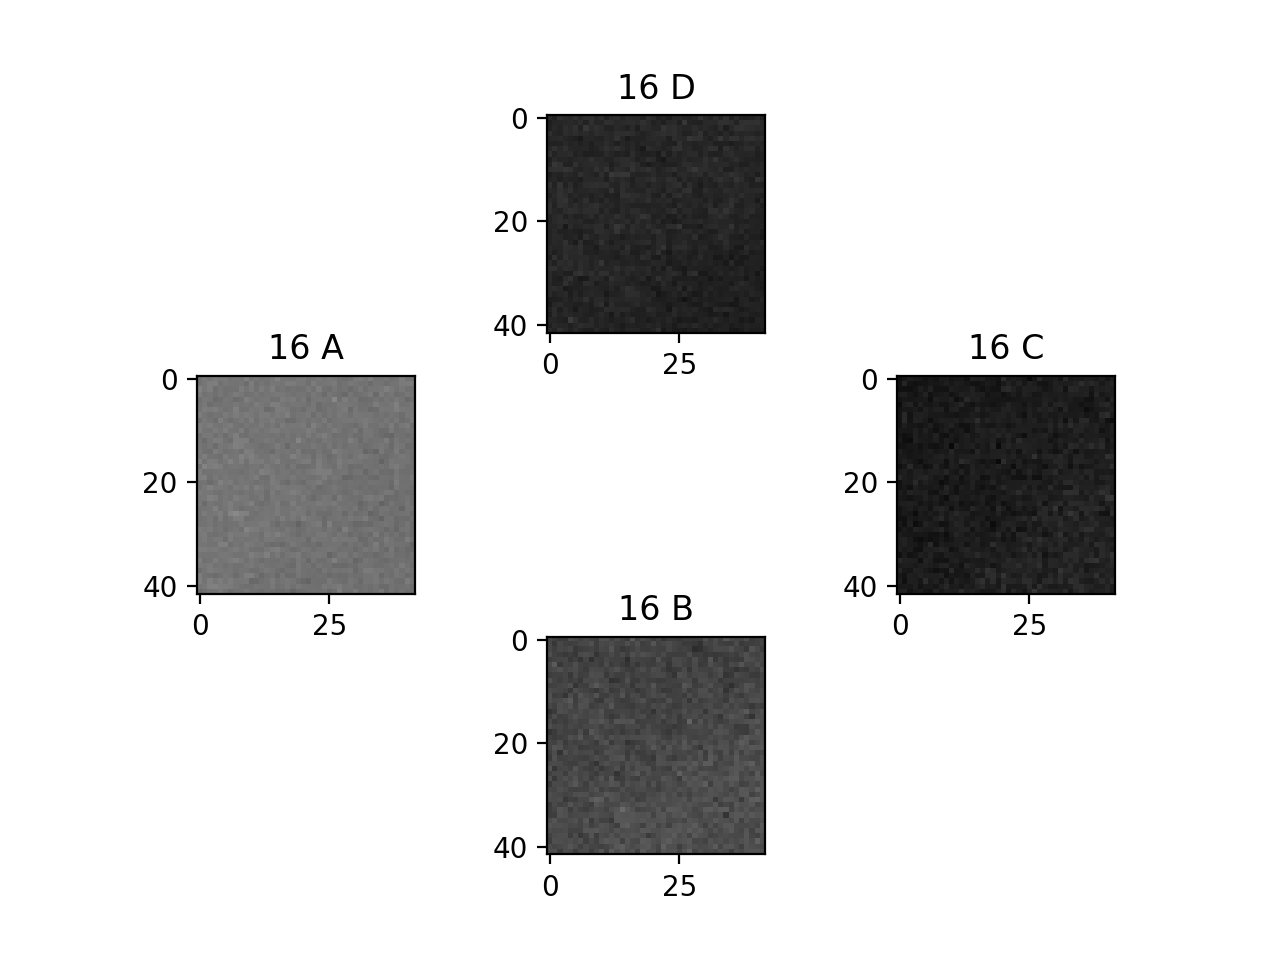

for segment  17
nx= 43
ny= 43
0 1 -4.749110317560579
0 2 -2.6891102685269566
0 3 1.660954248584105
1 2 5.909634961404795
1 3 -0.5445239359486899
2 3 -3.4197854194763693
Correlation score = 8.913997749028722



<IPython.core.display.Javascript object>


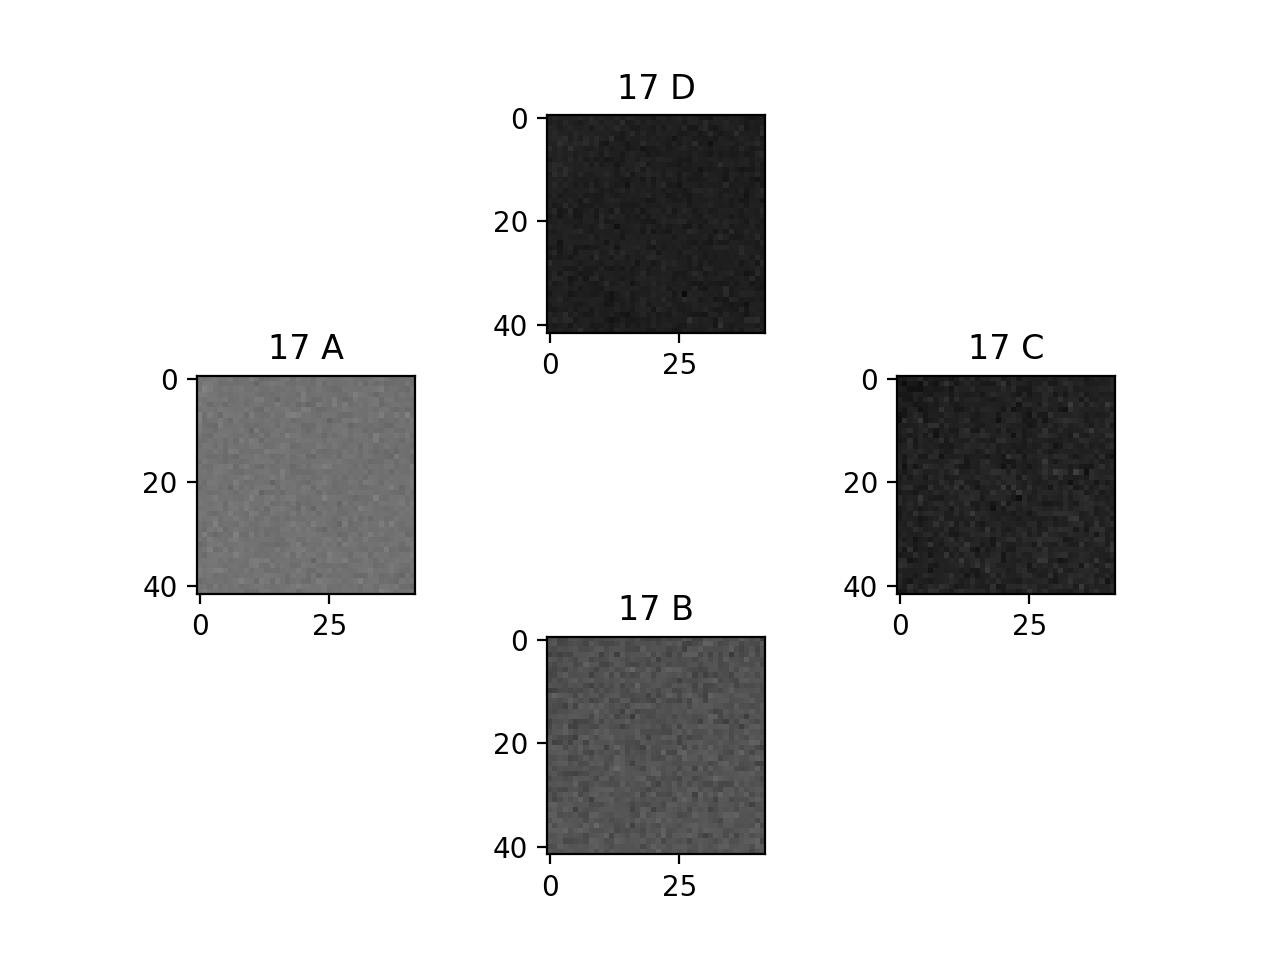

<IPython.core.display.Javascript object>


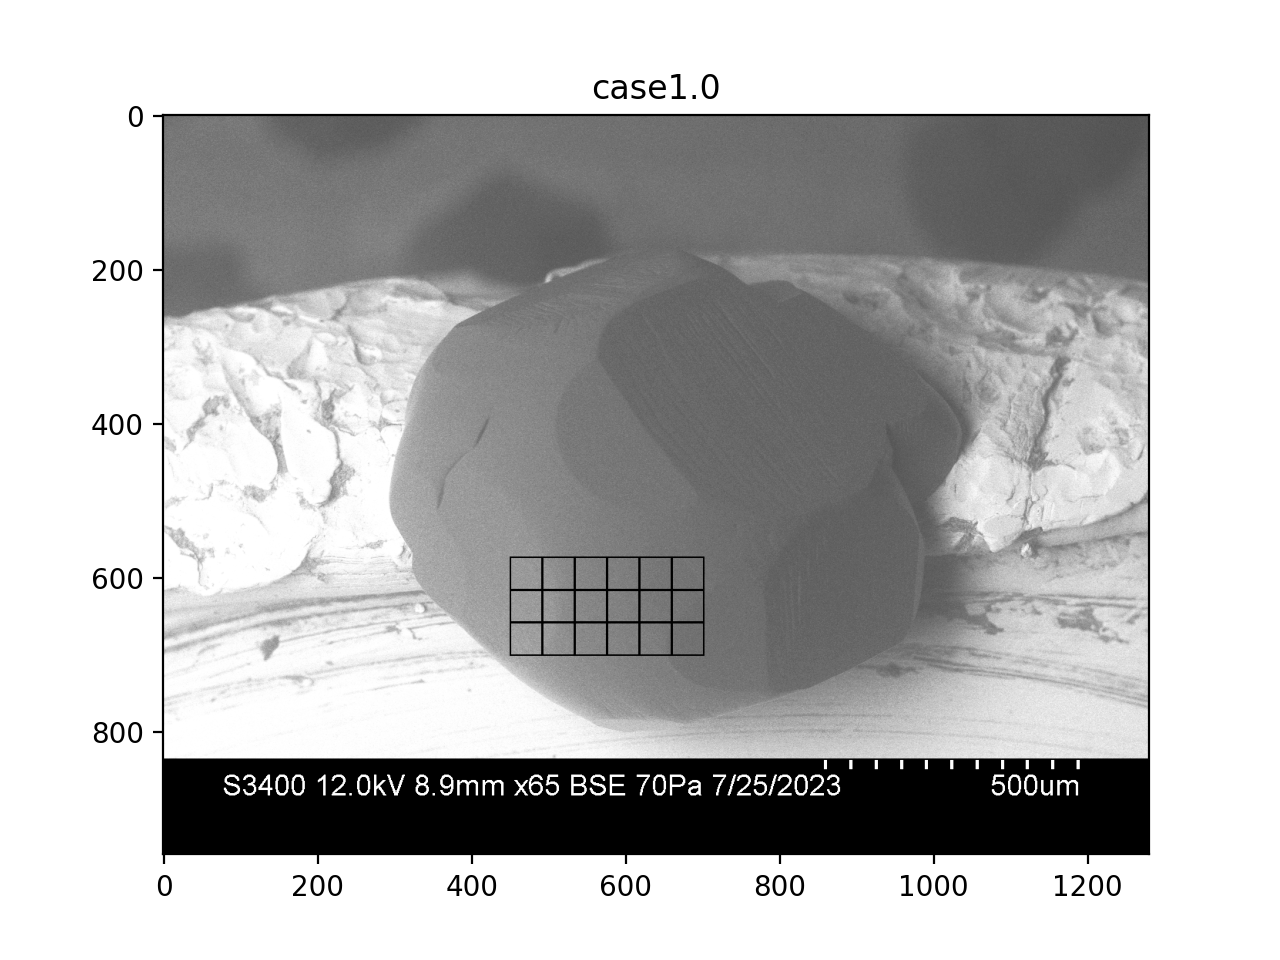

In [91]:
# Display
im = PIL.Image.open(Filename)

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments to the image
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),5)

# What's the random expectation of information content
print('Benchmark score for random signals =', sts.randomcorrelation(nacross,ndown)*100*3)
    
# Loop to evaluate the information content in each segment
print('Correlation of detectors A-D for each segment')
for isegment in range(nsegments):
    
    print('for segment ', isegment)
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1; print('nx=',nx)
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1; print('ny=',ny)
    cAseg = cA[ny1:ny2,nx1:nx2]; #cAsegmean = np.mean(cAseg); print('<cA> =',cAsegmean)
    cBseg = cB[ny1:ny2,nx1:nx2]; #cBsegmean = np.mean(cBseg); print('<cB> =',cBsegmean)
    cCseg = cC[ny1:ny2,nx1:nx2]; #cCsegmean = np.mean(cCseg); print('<cC> =',cCsegmean)
    cDseg = cD[ny1:ny2,nx1:nx2]; #cDsegmean = np.mean(cDseg); print('<cD> =',cDsegmean)
    cseg = [cAseg,cBseg,cCseg,cDseg]
    infoscore = sts.getinfoscore(cseg)
    print('Correlation score =', infoscore)
    print('')

    # Show what the detectors see
    plt.figure()
    plt.subplot(334); plt.imshow(np.asarray(cAseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' A')
    plt.subplot(338); plt.imshow(np.asarray(cBseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' B')
    plt.subplot(336); plt.imshow(np.asarray(cCseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' C')
    plt.subplot(332); plt.imshow(np.asarray(cDseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' D')

# Show it
plt.figure()
plt.imshow(np.asarray(im), cmap = 'Greys_r', vmin = 0, vmax = 255)
plt.title(imageroot)

# Save a copy
im.save(SEMSegmentjpgfile)

In [92]:
# Read and unpack the calibration data

# Just echo input data files  
print(Calibrationfile)

# Extract
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']

Calibration.nml


In [93]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [94]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes
nxigrid.shape

(101, 103)

In [95]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
rs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [96]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [97]:
# Generic retrieval parameters
maxiter = 5
tolerance = 10

In [98]:
# Create the a priori/solution set, and the uncertainty set
    
# Define the variance in the observations (BS units^2)
#noiseamp = 5.0
noiseamp = 25.0
print('Std deviation in input signal is', noiseamp**.5)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0

print('Std deviation in a priori is', apriorivar0**.5)

# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

Std deviation in input signal is 5.0
Std deviation in a priori is 15.0


In [99]:
# Loop to retrieve each segment
reload(rs)
for isegment in range(nsegments):
    
    # Choose the particular location of the dataset to analyze
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1

    # Construct gradients
    Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
    Ny = Ny_unscaled/dy
    Nx = -Nx_unscaled/dx #fixing x inversion
    
    # Number of observations
    nobs = (nx-1)*(ny-1)*4

    # Number of desired points (heights)
    nzpts = ny*nx-1
    
    # Extract the a priori variance
    vartemp = apriorivar[ny1:ny2+1,nx1:nx2+1]
    #vartemp_long = np.reshape(vartemp,nzpts+1,0) # This appears to have been deprecated
    vartemp_long = vartemp.flatten(order='C')
    Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)
    
    # Extract the starting z
    settemp = solution[ny1:ny2+1,nx1:nx2+1]
    #settemp_long = np.reshape(settemp,nzpts+1,0)
    settemp_long = settemp.flatten(order='C')
    settemp_longminus1 = settemp_long[:-1]
    z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
    z_start = z_start*0.0; #print "aprioriset", shape(z_start)

    # Construct the variance in observation + model
    Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

    # Do the retrieval
    print('')
    print("Segment:", isegment, '(', isegment+1, "of", nsegments, ')')
    print("for", nx1, ny1)
    z_retrieved = rs.retrievesegment(\
        nx1,ny1,nx2,ny2,cA,cB,cC,cD,\
        Sa,Se,z_start,maxiter,tolerance,\
        Nx,Ny,\
        Arule, Brule, Crule, Drule,\
        KAxrule, KAyrule, \
        KBxrule, KByrule, \
        KCxrule, KCyrule, \
        KDxrule, KDyrule)
    
    if isegment == 0:
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
    else:
        nextsolution = np.zeros(cA.shape)
        nextsolution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
        overlap = []
        for i in range(isegment):
            nextoverlap = list( set(nyxgrid[i])&set(nyxgrid[isegment]) )
            overlap = overlap + nextoverlap
            Noverlap = len(overlap); 
        print("Noverlap =", Noverlap)
        diff = 0.0
        for j in range(Noverlap):
            diff += nextsolution[overlap[j]] - solution[overlap[j]]
        diffavg = diff/Noverlap
        z_retrieved -= diffavg
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)


Segment: 0 ( 1 of 18 )
for 450 575
Observed intensities (detector B):
mean, max, min = 56.1468253968254 75.0 39.0
<diff>, std(diff), di2 = -2.451393819632397 13.975179227087036 38907.6498549653
<diff>, std(diff), di2 = -3.8506302400966095 6.634508302751386 1577.9812251005628
<diff>, std(diff), di2 = -4.015593303146992 5.864417018698567 47.10079372946039
<diff>, std(diff), di2 = -4.029397098121819 5.804966891545773 2.6211260177259197

Segment: 1 ( 2 of 18 )
for 450 617
Observed intensities (detector B):
mean, max, min = 61.06519274376417 84.0 43.0
<diff>, std(diff), di2 = -0.850628513509947 15.05611392323677 47560.161587603696
<diff>, std(diff), di2 = -2.6793900527051813 7.0496679556814215 2135.8342588566675
<diff>, std(diff), di2 = -2.885719849418566 6.137226347732209 68.73625529548606
<diff>, std(diff), di2 = -2.900460839051563 6.07652111211614 3.568094402930954
Noverlap = 43

Segment: 2 ( 3 of 18 )
for 450 659
Observed intensities (detector B):
mean, max, min = 67.95578231292517 89.

252
126


<IPython.core.display.Javascript object>


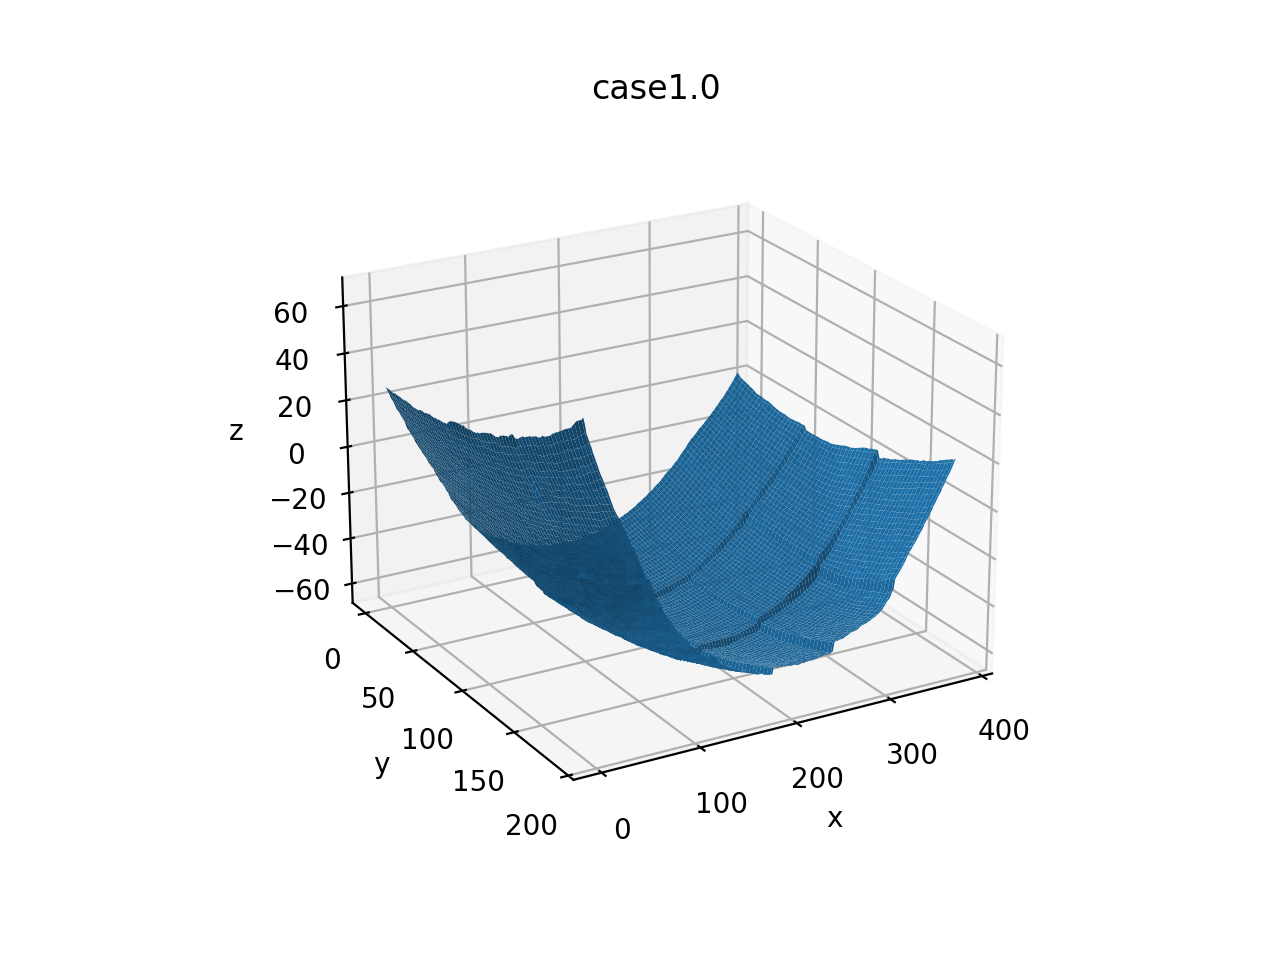

In [100]:
# Show the reconstructed surface
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=2,cstride=2)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(imageroot)
ax.view_init(azim=-120,elev=22)

In [101]:
# Save this data

#save an image
fig.savefig(Retrievedjpgfile)


print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=imageroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    pA=pA, \
                    pB=pB, \
                    pC=pC, \
                    pD=pD, \
                    sA=sA, \
                    sB=sB, \
                    sC=sC, \
                    sD=sD, \
                    nxi=nxi, \
                    nyi=nyi, \
                    dnx=dnx, \
                    dny=dny, \
                    solution=solution)

saving Segments1_retrieved
